In [69]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False
import gc


# 인코더 추가
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
#상수항추가
from statsmodels.tools.tools import add_constant
# 카이제곱, ANOVA
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
#Turkeyhsd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

### 데이터 불러오기

In [4]:
# parquet 파일 데이터를 읽어온다.
# x 값으로 쓸 데이터 
df1_train = pd.read_parquet('open/train/2.신용정보/201807_train_신용정보.parquet')
df2_train = pd.read_parquet('open/train/2.신용정보/201808_train_신용정보.parquet')
df3_train = pd.read_parquet('open/train/2.신용정보/201809_train_신용정보.parquet')
df4_train = pd.read_parquet('open/train/2.신용정보/201810_train_신용정보.parquet')
df5_train = pd.read_parquet('open/train/2.신용정보/201811_train_신용정보.parquet')
df6_train = pd.read_parquet('open/train/2.신용정보/201812_train_신용정보.parquet')

combined_df = pd.concat([df1_train, df2_train, df3_train, df4_train, df5_train, df6_train], axis=0, ignore_index=True)
combined_df

,기준년월,ID,최초한도금액,카드이용한도금액,CA한도금액,일시상환론한도금액,월상환론한도금액,CA이자율_할인전,CL이자율_할인전,RV일시불이자율_할인전,...,연체감액여부_R3M,한도심사요청건수,한도요청거절건수,한도심사요청후경과월,한도심사거절후경과월,시장단기연체여부_R6M,시장단기연체여부_R3M,시장연체상환여부_R6M,시장연체상환여부_R3M,rv최초시작후경과일
0,201807,TRAIN_000000,0,19354,7270,0,0,22.995207,18.254978,17.264967,...,0,0회,0,3,3,0,0,0,0,99999999
1,201807,TRAIN_000001,0,9996,5718,41996,90611,14.793821,14.834873,10.622446,...,0,0회,0,3,3,0,0,0,0,322
2,201807,TRAIN_000002,0,88193,35207,0,0,22.014276,17.875321,17.155829,...,0,0회,0,3,3,0,0,0,0,2378
3,201807,TRAIN_000003,0,19062,6531,0,0,22.998014,22.999453,19.293674,...,0,0회,0,3,3,0,0,0,0,99999999
4,201807,TRAIN_000004,0,177222,47149,48000,155020,14.661948,10.897410,10.654587,...,0,0회,0,3,3,0,0,0,0,99999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399995,201812,TRAIN_399995,0,20070,10167,0,54445,15.243670,11.900516,10.545876,...,0,0회,0,3,3,0,0,0,0,99999999
2399996,201812,TRAIN_399996,0,84217,31159,0,156800,14.843464,15.652063,11.102726,...,0,0회,0,3,3,0,0,0,0,99999999
2399997,201812,TRAIN_399997,0,52612,19429,0,0,17.038599,17.966213,13.278475,...,0,0회,0,3,3,0,0,0,0,99999999
2399998,201812,TRAIN_399998,0,10002,4228,90004,180906,15.182880,11.901089,10.594124,...,0,0회,0,3,3,0,0,0,0,99999999


In [5]:
# 결과데이터를 불러온다. 
segment_df = pd.read_csv('Segment.csv')
segment_df

,기준년월,ID,Segment
0,201807,TRAIN_000000,D
1,201807,TRAIN_000001,E
2,201807,TRAIN_000002,C
3,201807,TRAIN_000003,D
4,201807,TRAIN_000004,E
...,...,...,...
2399995,201812,TRAIN_399995,E
2399996,201812,TRAIN_399996,D
2399997,201812,TRAIN_399997,C
2399998,201812,TRAIN_399998,E


In [6]:
# 둘을 합쳐준다. 
# ID는 중복되는 값이 concat의 영향으로 6개씩 존재하므로
# 기준년월을 이용해 추가적인 기준을 만들어준다. 
all_df = combined_df.merge(segment_df, on=['ID', '기준년월'], how='left')
all_df

,기준년월,ID,최초한도금액,카드이용한도금액,CA한도금액,일시상환론한도금액,월상환론한도금액,CA이자율_할인전,CL이자율_할인전,RV일시불이자율_할인전,...,한도심사요청건수,한도요청거절건수,한도심사요청후경과월,한도심사거절후경과월,시장단기연체여부_R6M,시장단기연체여부_R3M,시장연체상환여부_R6M,시장연체상환여부_R3M,rv최초시작후경과일,Segment
0,201807,TRAIN_000000,0,19354,7270,0,0,22.995207,18.254978,17.264967,...,0회,0,3,3,0,0,0,0,99999999,D
1,201807,TRAIN_000001,0,9996,5718,41996,90611,14.793821,14.834873,10.622446,...,0회,0,3,3,0,0,0,0,322,E
2,201807,TRAIN_000002,0,88193,35207,0,0,22.014276,17.875321,17.155829,...,0회,0,3,3,0,0,0,0,2378,C
3,201807,TRAIN_000003,0,19062,6531,0,0,22.998014,22.999453,19.293674,...,0회,0,3,3,0,0,0,0,99999999,D
4,201807,TRAIN_000004,0,177222,47149,48000,155020,14.661948,10.897410,10.654587,...,0회,0,3,3,0,0,0,0,99999999,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399995,201812,TRAIN_399995,0,20070,10167,0,54445,15.243670,11.900516,10.545876,...,0회,0,3,3,0,0,0,0,99999999,E
2399996,201812,TRAIN_399996,0,84217,31159,0,156800,14.843464,15.652063,11.102726,...,0회,0,3,3,0,0,0,0,99999999,D
2399997,201812,TRAIN_399997,0,52612,19429,0,0,17.038599,17.966213,13.278475,...,0회,0,3,3,0,0,0,0,99999999,C
2399998,201812,TRAIN_399998,0,10002,4228,90004,180906,15.182880,11.901089,10.594124,...,0회,0,3,3,0,0,0,0,99999999,E


In [123]:
all_df.isna().sum()

최초한도금액                  0
카드이용한도금액                0
CA한도금액                  0
일시상환론한도금액               0
월상환론한도금액                0
CA이자율_할인전               0
CL이자율_할인전               0
RV일시불이자율_할인전            0
RV현금서비스이자율_할인전          0
RV신청일자            1951236
RV약정청구율                 0
RV최소결제비율                0
자발한도감액횟수_R12M           0
자발한도감액금액_R12M           0
자발한도감액후경과월              0
강제한도감액횟수_R12M           0
강제한도감액금액_R12M           0
강제한도감액후경과월              0
한도증액횟수_R12M             0
한도증액금액_R12M             0
한도증액후경과월                0
상향가능한도금액                0
상향가능CA한도금액              0
카드론동의여부                 0
월상환론상향가능한도금액            0
RV전환가능여부                0
일시불ONLY전환가능여부           0
카드이용한도금액_B1M            0
카드이용한도금액_B2M            0
특별한도보유여부_R3M            0
연체감액여부_R3M              0
한도심사요청건수                0
한도요청거절건수                0
한도심사요청후경과월              0
한도심사거절후경과월              0
시장단기연체여부_R6M            0
시장단기연체여부_R3M            0
시장연체상환여부_R6M            0
시장연체상환여부_R3M

### 변수간 관계파악
Anova -> ETA제곱
카이제곱 -> 크레이머스V

In [65]:
# 사용자 정의 수치형, 범주형 컬럼
categorical_cols = [
    '자발한도감액횟수_R12M',
    '자발한도감액금액_R12M',
    '자발한도감액후경과월',
    '강제한도감액횟수_R12M',
    '강제한도감액금액_R12M',
    '강제한도감액후경과월',
    '카드론동의여부',
    '월상환론상향가능한도금액',
    'RV전환가능여부',
    '일시불ONLY전환가능여부',
    '특별한도보유여부_R3M',
    '연체감액여부_R3M',
    '한도증액횟수_R12M',
    '한도증액금액_R12M',
    '한도증액후경과월',
    '상향가능한도금액',
    '상향가능CA한도금액',
    '한도심사요청건수',
    '한도요청거절건수',
    '한도심사요청후경과월',
    '한도심사거절후경과월',
    '시장단기연체여부_R6M',
    '시장단기연체여부_R3M',
    '시장연체상환여부_R6M',
    'rv최초시작후경과일'
]


numerical_cols = ['최초한도금액',
 '카드이용한도금액',
 'CA한도금액',
 '일시상환론한도금액',
 '월상환론한도금액',
 'CA이자율_할인전',
 'CL이자율_할인전','RV일시불이자율_할인전',
 'RV현금서비스이자율_할인전',
 'RV약정청구율',
 'RV최소결제비율',
 '카드이용한도금액_B1M',
 '카드이용한도금액_B2M']

# 계수 계산 함수
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k, r) - 1)))

def eta_squared(anova_ss_between, total_ss):
    return anova_ss_between / total_ss if total_ss != 0 else np.nan

# 결과 저장
anova = []
chi = []

for col in numerical_cols:
    if col not in all_df.columns:
        continue
    data = all_df[[col, 'Segment']].dropna()
    groups = [data[data['Segment'] == val][col] for val in data['Segment'].unique()]
    try:
        stat = f_oneway(*groups).statistic
        ss_between = sum([(g.mean() - data[col].mean())**2 * len(g) for g in groups])
        ss_total = sum((data[col] - data[col].mean())**2)
        eta2 = eta_squared(ss_between, ss_total)
        anova.append({'변수': col, '유형': '수치형', '계수종류': 'Eta²', '상관계수': eta2})
    except:
        continue

for col in categorical_cols:
    if col not in all_df.columns:
        continue
    contingency = pd.crosstab(all_df[col], all_df['Segment'])
    if contingency.shape[0] > 1 and contingency.shape[1] > 1:
        try:
            v = cramers_v(contingency)
            chi.append({'변수': col, '유형': '범주형', '계수종류': "Cramér's V", '상관계수': v})
        except:
            continue

# 결과 정리 및 정렬
result_df1 = pd.DataFrame(anova)
result_df2 = pd.DataFrame(chi)

if '상관계수' in result_df1.columns:
    result_df1 = result_df1.sort_values(by='상관계수', ascending=False).reset_index(drop=True)

if '상관계수' in result_df2.columns:
    result_df2 = result_df2.sort_values(by='상관계수', ascending=False).reset_index(drop=True)

# 결과 출력
display(result_df1)
display(result_df2)

,변수,유형,계수종류,상관계수
0,카드이용한도금액,수치형,Eta²,0.093356
1,카드이용한도금액_B2M,수치형,Eta²,0.092755
2,카드이용한도금액_B1M,수치형,Eta²,0.092747
3,CA한도금액,수치형,Eta²,0.085807
4,CA이자율_할인전,수치형,Eta²,0.014079
5,최초한도금액,수치형,Eta²,0.011621
6,RV현금서비스이자율_할인전,수치형,Eta²,0.009658
7,일시상환론한도금액,수치형,Eta²,0.008916
8,RV일시불이자율_할인전,수치형,Eta²,0.005760
9,RV약정청구율,수치형,Eta²,0.004578


,변수,유형,계수종류,상관계수
0,상향가능한도금액,범주형,Cramér's V,0.141612
1,상향가능CA한도금액,범주형,Cramér's V,0.136274
2,한도증액금액_R12M,범주형,Cramér's V,0.078676
3,rv최초시작후경과일,범주형,Cramér's V,0.070303
4,한도증액횟수_R12M,범주형,Cramér's V,0.070096
5,RV전환가능여부,범주형,Cramér's V,0.044128
6,카드론동의여부,범주형,Cramér's V,0.038021
7,강제한도감액후경과월,범주형,Cramér's V,0.029208
8,강제한도감액금액_R12M,범주형,Cramér's V,0.028309
9,한도증액후경과월,범주형,Cramér's V,0.027772


In [ ]:
pd.to_excel

### corr 상관계수

In [11]:
# all_df에서 기준년월, ID 컬럼은 제거한다. 
all_df = all_df.drop(['기준년월','ID'], axis=1)
# 컬럼들을 리스트에 담아 확인한다
column_list = all_df.columns.tolist()
column_list

['최초한도금액',
 '카드이용한도금액',
 'CA한도금액',
 '일시상환론한도금액',
 '월상환론한도금액',
 'CA이자율_할인전',
 'CL이자율_할인전',
 'RV일시불이자율_할인전',
 'RV현금서비스이자율_할인전',
 'RV신청일자',
 'RV약정청구율',
 'RV최소결제비율',
 '자발한도감액횟수_R12M',
 '자발한도감액금액_R12M',
 '자발한도감액후경과월',
 '강제한도감액횟수_R12M',
 '강제한도감액금액_R12M',
 '강제한도감액후경과월',
 '한도증액횟수_R12M',
 '한도증액금액_R12M',
 '한도증액후경과월',
 '상향가능한도금액',
 '상향가능CA한도금액',
 '카드론동의여부',
 '월상환론상향가능한도금액',
 'RV전환가능여부',
 '일시불ONLY전환가능여부',
 '카드이용한도금액_B1M',
 '카드이용한도금액_B2M',
 '특별한도보유여부_R3M',
 '연체감액여부_R3M',
 '한도심사요청건수',
 '한도요청거절건수',
 '한도심사요청후경과월',
 '한도심사거절후경과월',
 '시장단기연체여부_R6M',
 '시장단기연체여부_R3M',
 '시장연체상환여부_R6M',
 '시장연체상환여부_R3M',
 'rv최초시작후경과일',
 'Segment']

In [12]:
# A가 가장 높은 등급일 것이라 추측하고 세그먼트만 LabelEncoder가 아닌 map으로 진행

segment_order = {'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4}
all_df['Segment_e'] = all_df['Segment'].map(segment_order)

# 인코딩 진행
# 인코딩할 컬럼만 선택
encoder = LabelEncoder()
all_df['한도심사요청건수'] = encoder.fit_transform(all_df['한도심사요청건수'])
all_df['카드론동의여부'] = encoder.fit_transform(all_df['카드론동의여부'])
all_df['한도증액횟수_R12M'] = encoder.fit_transform(all_df['한도증액횟수_R12M'])
all_df['자발한도감액횟수_R12M'] = encoder.fit_transform(all_df['자발한도감액횟수_R12M'])
all_df['RV전환가능여부'] = encoder.fit_transform(all_df['RV전환가능여부'])



In [13]:
print(all_df['Segment_e'].unique())

[1 0 2 4 3]


In [127]:
all_df['시장연체상환여부_R3M'].value_counts()

시장연체상환여부_R3M
0    2400000
Name: count, dtype: int64

In [101]:

# 리스트를 나눠준다. 
### 수치형
column1 = ['최초한도금액',
 '카드이용한도금액',
 'CA한도금액',
 '일시상환론한도금액',
 '월상환론한도금액',
 'CA이자율_할인전',
 'CL이자율_할인전']
          
column2 = ['RV일시불이자율_할인전',
 'RV현금서비스이자율_할인전',
 'RV약정청구율',
 'RV최소결제비율',
 '카드이용한도금액_B1M',
 '카드이용한도금액_B2M']

### 범주형

column3 = ['자발한도감액횟수_R12M',
 '자발한도감액금액_R12M',
 '자발한도감액후경과월',
 '강제한도감액횟수_R12M',
 '강제한도감액금액_R12M',
 '강제한도감액후경과월']

column4 = ['카드론동의여부',
 '월상환론상향가능한도금액',
 'RV전환가능여부',
 '일시불ONLY전환가능여부',
 '특별한도보유여부_R3M',
 '연체감액여부_R3M']

column5 = ['한도증액횟수_R12M',
 '한도증액금액_R12M',
 '한도증액후경과월',
 '상향가능한도금액',
 '상향가능CA한도금액']

column6 = ['한도심사요청건수',
 '한도요청거절건수',
 '한도심사요청후경과월',
 '한도심사거절후경과월',
 '시장단기연체여부_R6M',
 '시장단기연체여부_R3M',
 '시장연체상환여부_R6M',
 'rv최초시작후경과일']



- 시장연체상환여부_R3M 컬럼의 경우 데이터가 모두 0이라서 제거했다

In [103]:
# 비교할 종속변수
target = 'Segment_e'
# 결과를 담을 리스트 
corr_result = []
# 반복
for col in column1:
    if col in all_df.columns:
        corr = all_df[col].corr(all_df[target])
        corr_result.append({'변수': col, '상관계수': corr})

# 데이터프레임으로 정리한다 
result_df3 = pd.DataFrame(corr_result).sort_values(by='상관계수', key=abs, ascending=False).reset_index(drop=True)

display(result_df3)

,변수,상관계수
0,카드이용한도금액,0.304435
1,CA한도금액,0.292502
2,CA이자율_할인전,0.118189
3,최초한도금액,0.107069
4,일시상환론한도금액,0.094197
5,월상환론한도금액,0.050272
6,CL이자율_할인전,0.037266


In [104]:
# 비교할 종속변수
target = 'Segment_e'
# 결과를 담을 리스트 
corr_result = []
# 반복
for col in column2:
    if col in all_df.columns:
        corr = all_df[col].corr(all_df[target])
        corr_result.append({'변수': col, '상관계수': corr})

# 데이터프레임으로 정리한다 
result_df4 = pd.DataFrame(corr_result).sort_values(by='상관계수', key=abs, ascending=False).reset_index(drop=True)

display(result_df4)

,변수,상관계수
0,카드이용한도금액_B1M,0.303262
1,카드이용한도금액_B2M,0.303258
2,RV현금서비스이자율_할인전,0.096870
3,RV일시불이자율_할인전,0.073838
4,RV약정청구율,0.054575
5,RV최소결제비율,0.031680


In [105]:
# 비교할 종속변수
target = 'Segment_e'
# 결과를 담을 리스트 
corr_result = []
# 반복
for col in column3:
    if col in all_df.columns:
        corr = all_df[col].corr(all_df[target])
        corr_result.append({'변수': col, '상관계수': corr})

# 데이터프레임으로 정리한다 
result_df5 = pd.DataFrame(corr_result).sort_values(by='상관계수', key=abs, ascending=False).reset_index(drop=True)

display(result_df5)

,변수,상관계수
0,강제한도감액후경과월,0.044601
1,강제한도감액금액_R12M,-0.037438
2,자발한도감액금액_R12M,0.006141
3,자발한도감액횟수_R12M,0.005818
4,강제한도감액횟수_R12M,-0.003853
5,자발한도감액후경과월,-0.002105


In [106]:
# 비교할 종속변수
target = 'Segment_e'
# 결과를 담을 리스트 
corr_result = []
# 반복
for col in column4:
    if col in all_df.columns:
        corr = all_df[col].corr(all_df[target])
        corr_result.append({'변수': col, '상관계수': corr})

# 데이터프레임으로 정리한다 
result_df6 = pd.DataFrame(corr_result).sort_values(by='상관계수', key=abs, ascending=False).reset_index(drop=True)

display(result_df6)

,변수,상관계수
0,RV전환가능여부,-0.047867
1,카드론동의여부,0.036400
2,일시불ONLY전환가능여부,-0.019205
3,연체감액여부_R3M,0.013670
4,월상환론상향가능한도금액,-0.011388
5,특별한도보유여부_R3M,-0.002992


In [108]:
# 비교할 종속변수
target = 'Segment_e'
# 결과를 담을 리스트 
corr_result = []
# 반복
for col in column5:
    if col in all_df.columns:
        corr = all_df[col].corr(all_df[target])
        corr_result.append({'변수': col, '상관계수': corr})

# 데이터프레임으로 정리한다 
result_df7 = pd.DataFrame(corr_result).sort_values(by='상관계수', key=abs, ascending=False).reset_index(drop=True)

display(result_df7)

,변수,상관계수
0,한도증액금액_R12M,0.084180
1,상향가능CA한도금액,0.064575
2,한도증액횟수_R12M,0.060724
3,상향가능한도금액,0.050764
4,한도증액후경과월,-0.039390


In [109]:
# 비교할 종속변수
target = 'Segment_e'
# 결과를 담을 리스트 
corr_result = []
# 반복
for col in column6:
    if col in all_df.columns:
        corr = all_df[col].corr(all_df[target])
        corr_result.append({'변수': col, '상관계수': corr})

# 데이터프레임으로 정리한다 
result_df8 = pd.DataFrame(corr_result).sort_values(by='상관계수', key=abs, ascending=False).reset_index(drop=True)

display(result_df8)

,변수,상관계수
0,rv최초시작후경과일,-0.070155
1,한도심사요청건수,0.001884
2,한도요청거절건수,0.001737
3,한도심사거절후경과월,-0.001724
4,시장단기연체여부_R6M,-0.001308
5,한도심사요청후경과월,-0.001212
6,시장단기연체여부_R3M,-0.001072
7,시장연체상환여부_R6M,-0.000298


In [110]:
corr_df = pd.concat(
    [result_df3, result_df4, result_df5, result_df6, result_df7, result_df8],
    axis=0,
    ignore_index=True
)

In [112]:
corr_result_df = corr_df.sort_values(by='상관계수', ascending=False).reset_index(drop=True)
corr_result_df

,변수,상관계수
0,카드이용한도금액,0.304435
1,카드이용한도금액_B1M,0.303262
2,카드이용한도금액_B2M,0.303258
3,CA한도금액,0.292502
4,CA이자율_할인전,0.118189
5,최초한도금액,0.107069
6,RV현금서비스이자율_할인전,0.096870
7,일시상환론한도금액,0.094197
8,한도증액금액_R12M,0.084180
9,RV일시불이자율_할인전,0.073838


In [119]:
result_AK = pd.concat(
    [result_df1, result_df2],
    axis=0,
    ignore_index=True
)
display(result_AK)

,변수,유형,계수종류,상관계수
0,카드이용한도금액,수치형,Eta²,0.093356
1,카드이용한도금액_B2M,수치형,Eta²,0.092755
2,카드이용한도금액_B1M,수치형,Eta²,0.092747
3,CA한도금액,수치형,Eta²,0.085807
4,CA이자율_할인전,수치형,Eta²,0.014079
5,최초한도금액,수치형,Eta²,0.011621
6,RV현금서비스이자율_할인전,수치형,Eta²,0.009658
7,일시상환론한도금액,수치형,Eta²,0.008916
8,RV일시불이자율_할인전,수치형,Eta²,0.005760
9,RV약정청구율,수치형,Eta²,0.004578


In [129]:
### 내보낸다. 
result_AK.to_excel('신용정보_상관계수.xlsx', index=False)
corr_result_df.to_excel('신용정보_검사.xlsx', index=False)


### VIF

In [23]:
# 사용할 수치형 변수 리스트
features = ['최초한도금액', '카드이용한도금액',
       'CA한도금액', 'CA이자율_할인전', '카드이용한도금액_B1M',
       '카드이용한도금액_B2M']
features1 = ['최초한도금액',
       'CA이자율_할인전',
       'CA한도금액']
features2 = ['최초한도금액', '카드이용한도금액',
       'CA한도금액', 'CA이자율_할인전', '카드이용한도금액_B2M']
# 독립변수 데이터
X = all_df[features2]
X = add_constant(X)  # 상수항 추가

# VIF 계산
vif_df = pd.DataFrame()
vif_df['Feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

        Feature        VIF
0         const  54.048339
1        최초한도금액   1.019199
2      카드이용한도금액  19.091935
3        CA한도금액   7.152437
4     CA이자율_할인전   1.064573
5  카드이용한도금액_B2M  16.313782


In [24]:
all_df[column5].corr()

,한도증액횟수_R12M,한도증액금액_R12M,한도증액후경과월,상향가능한도금액,상향가능CA한도금액,Segment_e
한도증액횟수_R12M,1.000000,0.941650,-0.819507,0.032296,0.034784,0.060724
한도증액금액_R12M,0.941650,1.000000,-0.763369,0.036540,0.040480,0.084180
한도증액후경과월,-0.819507,-0.763369,1.000000,0.003790,0.001530,-0.039390
상향가능한도금액,0.032296,0.036540,0.003790,1.000000,0.963278,0.050764
상향가능CA한도금액,0.034784,0.040480,0.001530,0.963278,1.000000,0.064575
Segment_e,0.060724,0.084180,-0.039390,0.050764,0.064575,1.000000


### CramersV

In [26]:
# 범주형 vs 범주형: Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.shape[0] < 2 or confusion_matrix.shape[1] < 2:
        return np.nan  # 최소 2x2 이상 필요
    try:
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        return np.sqrt(phi2 / min(k - 1, r - 1))
    except:
        return np.nan


In [27]:
combined_categorical_cols = [
    '자발한도감액횟수_R12M',
    '자발한도감액금액_R12M',
    '자발한도감액후경과월',
    '강제한도감액횟수_R12M',
    '강제한도감액금액_R12M',
    '강제한도감액후경과월',
    '카드론동의여부',
    '월상환론상향가능한도금액',
    'RV전환가능여부',
    '일시불ONLY전환가능여부',
    '특별한도보유여부_R3M',
    '연체감액여부_R3M',
    '한도증액횟수_R12M',
    '한도증액금액_R12M',
    '한도증액후경과월',
    '상향가능한도금액',
    '상향가능CA한도금액',
    '한도심사요청건수',
    '한도요청거절건수',
    '한도심사요청후경과월',
    '한도심사거절후경과월',
    '시장단기연체여부_R6M',
    '시장단기연체여부_R3M',
    '시장연체상환여부_R6M',
    'rv최초시작후경과일'
]


numerical_cols = ['최초한도금액',
 '카드이용한도금액',
 'CA한도금액',
 '일시상환론한도금액',
 '월상환론한도금액',
 'CA이자율_할인전',
 'CL이자율_할인전','RV일시불이자율_할인전',
 'RV현금서비스이자율_할인전',
 'RV약정청구율',
 'RV최소결제비율',
 '카드이용한도금액_B1M',
 '카드이용한도금액_B2M']

In [28]:
# 변수 정의
segment_col = 'Segment'
categorical_cols = combined_categorical_cols  # Segment_e 제외된 범주형 컬럼 리스트

results = []

for col in categorical_cols:
    if col == segment_col:
        continue

    coeff = cramers_v(all_df[segment_col], all_df[col])
    coef_type = "Cramér's V"
    var_type = "범주형"

    results.append({
        '변수': col,
        '유형': var_type,
        '계수종류': coef_type,
        '상관계수': round(coeff, 6) if not pd.isna(coeff) else np.nan
    })

correlation_df = pd.DataFrame(results).sort_values(by='상관계수', ascending=False)
display(correlation_df)



,변수,유형,계수종류,상관계수
15,상향가능한도금액,범주형,Cramér's V,0.141612
16,상향가능CA한도금액,범주형,Cramér's V,0.136274
13,한도증액금액_R12M,범주형,Cramér's V,0.078676
24,rv최초시작후경과일,범주형,Cramér's V,0.070303
12,한도증액횟수_R12M,범주형,Cramér's V,0.070096
8,RV전환가능여부,범주형,Cramér's V,0.044128
6,카드론동의여부,범주형,Cramér's V,0.038021
5,강제한도감액후경과월,범주형,Cramér's V,0.029208
4,강제한도감액금액_R12M,범주형,Cramér's V,0.028309
14,한도증액후경과월,범주형,Cramér's V,0.027772


모든 조합이 True라면 Segment마다 평균이 모두 달라 매우 유의미한 변수

### ANOVA & Turkey

In [31]:

segment_col = 'Segment'
results = []

for col in numerical_cols:  # 수치형 변수 리스트
    try:
        groups = [all_df[all_df[segment_col] == grp][col].dropna() for grp in all_df[segment_col].unique()]
        if len(groups) < 2 or any(len(g) < 2 for g in groups):
            continue  # 그룹 수가 부족하면 skip

        f_stat, p_value = f_oneway(*groups)

        results.append({
            '변수': col,
            'F-stat': round(f_stat, 4),
            'p-value': round(p_value, 6),
            '유의함': '✅' if p_value < 0.05 else ''
        })
    except:
        continue

anova_df = pd.DataFrame(results).sort_values(by='p-value')
display(anova_df)

,변수,F-stat,p-value,유의함
0,최초한도금액,7054.3792,0.0,✅
1,카드이용한도금액,61781.0560,0.0,✅
2,CA한도금액,56316.7372,0.0,✅
3,일시상환론한도금액,5397.9734,0.0,✅
4,월상환론한도금액,1619.5758,0.0,✅
5,CA이자율_할인전,8568.2997,0.0,✅
6,CL이자율_할인전,856.6302,0.0,✅
7,RV일시불이자율_할인전,3476.1918,0.0,✅
8,RV현금서비스이자율_할인전,5851.6036,0.0,✅
9,RV약정청구율,2759.5715,0.0,✅


In [32]:


# 1. ANOVA: Segment에 따라 평균차이 있는지
def run_anova(df, target_col, feature_col):
    groups = [df[df[target_col] == g][feature_col].dropna() for g in df[target_col].unique()]
    return f_oneway(*groups)

# 2. Tukey HSD: 그룹 간 차이 상세 분석
def run_tukey(df, target_col, feature_col):
    tukey = pairwise_tukeyhsd(df[feature_col], df[target_col], alpha=0.05)
    return pd.DataFrame(tukey.summary().data[1:], columns=tukey.summary().data[0])

# 3. 시각화
def plot_box(df, group_col, target_col):
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=group_col, y=target_col, data=df)
    plt.title(f'Boxplot of {target_col} by {group_col}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



📌 유의한 변수: 최초한도금액 → Tukey HSD & Boxplot 진행 중...


,group1,group2,meandiff,p-adj,lower,upper,reject
0,A,B,-6437.5278,0.0000,-8951.8833,-3923.1723,True
1,A,C,-3312.3580,0.0000,-4218.9749,-2405.7410,True
2,A,D,-5931.1382,0.0000,-6835.5773,-5026.6990,True
3,A,E,-7692.2781,0.0000,-8595.6896,-6788.8666,True
4,B,C,3125.1698,0.0026,777.3073,5473.0323,True
5,B,D,506.3896,0.9768,-1840.6328,2853.4120,False
6,B,E,-1254.7503,0.5896,-3601.3769,1091.8762,False
7,C,D,-2618.7802,0.0000,-2710.8931,-2526.6674,True
8,C,E,-4379.9202,0.0000,-4461.3263,-4298.5140,True
9,D,E,-1761.1399,0.0000,-1812.9364,-1709.3435,True


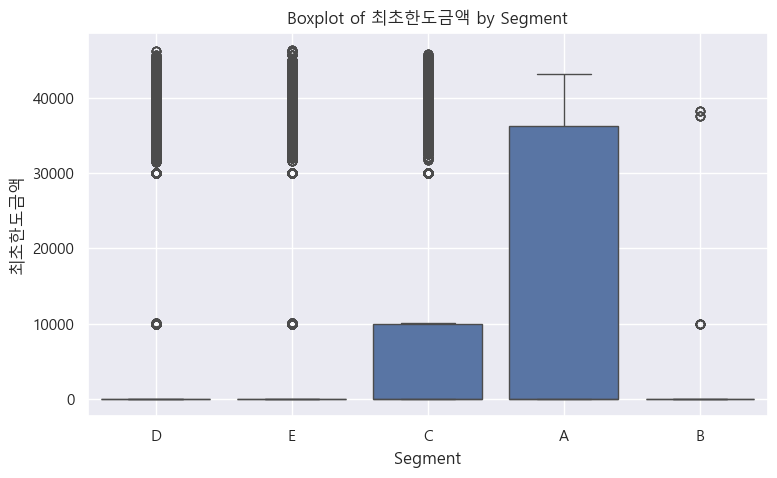


📌 유의한 변수: 카드이용한도금액 → Tukey HSD & Boxplot 진행 중...


,group1,group2,meandiff,p-adj,lower,upper,reject
0,A,B,-71198.7073,0.0,-81974.0459,-60423.3687,True
1,A,C,-99581.7314,0.0,-103467.0628,-95696.4001,True
2,A,D,-128277.2198,0.0,-132153.2183,-124401.2214,True
3,A,E,-152350.3775,0.0,-156221.9719,-148478.7830,True
4,B,C,-28383.0241,0.0,-38444.8523,-18321.1959,True
5,B,D,-57078.5125,0.0,-67136.7406,-47020.2845,True
6,B,E,-81151.6702,0.0,-91208.2019,-71095.1384,True
7,C,D,-28695.4884,0.0,-29090.2404,-28300.7364,True
8,C,E,-52768.6460,0.0,-53117.5142,-52419.7779,True
9,D,E,-24073.1576,0.0,-24295.1326,-23851.1826,True


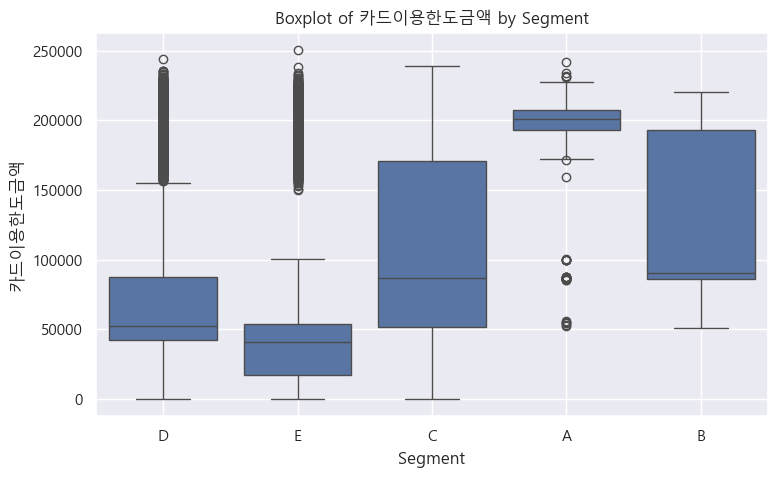


📌 유의한 변수: CA한도금액 → Tukey HSD & Boxplot 진행 중...


,group1,group2,meandiff,p-adj,lower,upper,reject
0,A,B,-17282.7611,0.0,-20629.6358,-13935.8863,True
1,A,C,-25269.1695,0.0,-26475.9732,-24062.3659,True
2,A,D,-33338.1744,0.0,-34542.0791,-32134.2696,True
3,A,E,-40738.9419,0.0,-41941.4788,-39536.4050,True
4,B,C,-7986.4085,0.0,-11111.6633,-4861.1536,True
5,B,D,-16055.4133,0.0,-19179.5499,-12931.2767,True
6,B,E,-23456.1808,0.0,-26579.7906,-20332.5711,True
7,C,D,-8069.0048,0.0,-8191.6168,-7946.3928,True
8,C,E,-15469.7724,0.0,-15578.1326,-15361.4121,True
9,D,E,-7400.7675,0.0,-7469.7141,-7331.8210,True


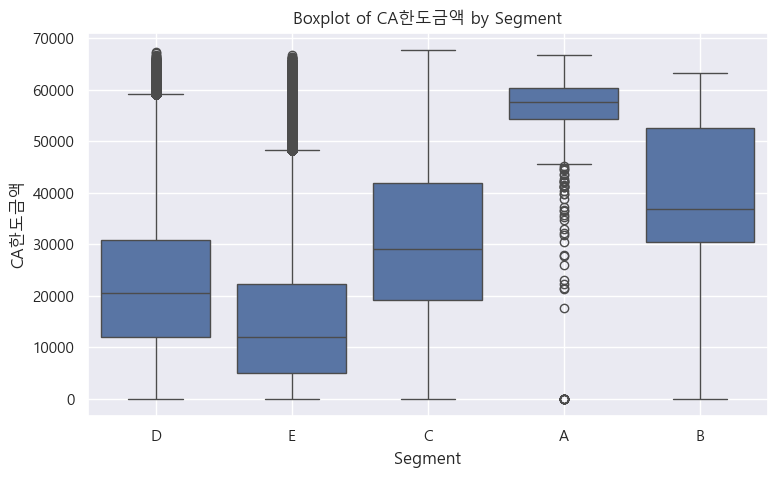


📌 유의한 변수: 일시상환론한도금액 → Tukey HSD & Boxplot 진행 중...


,group1,group2,meandiff,p-adj,lower,upper,reject
0,A,B,-18959.4231,0.0003,-31445.7578,-6473.0884,True
1,A,C,-3617.0232,0.1828,-8119.2992,885.2528,False
2,A,D,-12710.1009,0.0000,-17201.5620,-8218.6399,True
3,A,E,-21561.8029,0.0000,-26048.1607,-17075.4451,True
4,B,C,15342.3999,0.0031,3682.8726,27001.9272,True
5,B,D,6249.3222,0.5869,-5406.0333,17904.6776,False
6,B,E,-2602.3798,0.9737,-14255.7696,9051.0100,False
7,C,D,-9093.0777,0.0000,-9550.5117,-8635.6438,True
8,C,E,-17944.7797,0.0000,-18349.0440,-17540.5154,True
9,D,E,-8851.7020,0.0000,-9108.9240,-8594.4800,True


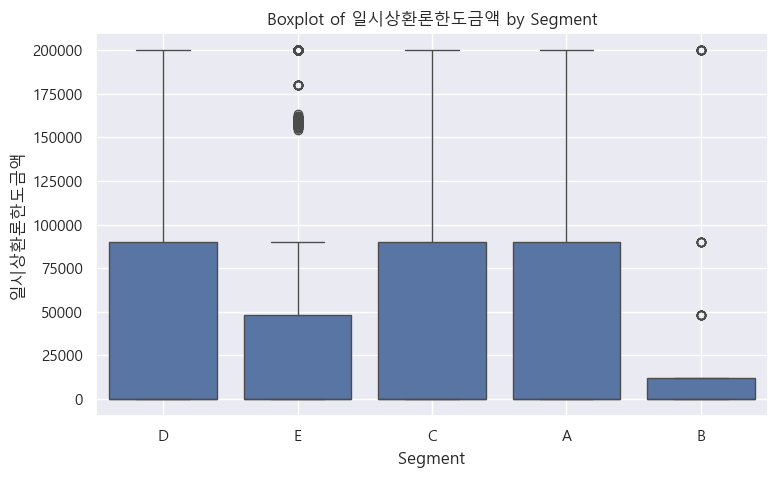


📌 유의한 변수: 월상환론한도금액 → Tukey HSD & Boxplot 진행 중...


,group1,group2,meandiff,p-adj,lower,upper,reject
0,A,B,-37108.1299,0.0000,-57712.0237,-16504.2361,True
1,A,C,267.1385,1.0000,-7162.1366,7696.4137,False
2,A,D,-3115.8353,0.7815,-10527.2646,4295.5940,False
3,A,E,-13072.2143,0.0000,-20475.2226,-5669.2060,True
4,B,C,37375.2684,0.0000,18135.7022,56614.8346,True
5,B,D,33992.2946,0.0000,14759.6124,53224.9767,True
6,B,E,24035.9156,0.0059,4806.4770,43265.3542,True
7,C,D,-3382.9739,0.0000,-4137.7927,-2628.1550,True
8,C,E,-13339.3528,0.0000,-14006.4356,-12672.2701,True
9,D,E,-9956.3790,0.0000,-10380.8250,-9531.9330,True


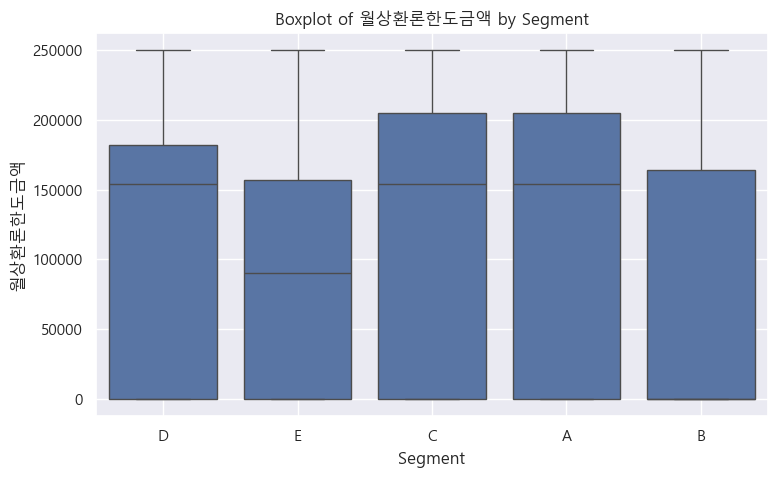


📌 유의한 변수: CA이자율_할인전 → Tukey HSD & Boxplot 진행 중...


,group1,group2,meandiff,p-adj,lower,upper,reject
0,A,B,1.8308,0.0000,1.2560,2.4056,True
1,A,C,-0.1824,0.1151,-0.3896,0.0249,False
2,A,D,-0.6342,0.0000,-0.8410,-0.4274,True
3,A,E,-1.1794,0.0000,-1.3860,-0.9729,True
4,B,C,-2.0132,0.0000,-2.5499,-1.4765,True
5,B,D,-2.4650,0.0000,-3.0016,-1.9285,True
6,B,E,-3.0103,0.0000,-3.5467,-2.4738,True
7,C,D,-0.4518,0.0000,-0.4729,-0.4307,True
8,C,E,-0.9970,0.0000,-1.0157,-0.9784,True
9,D,E,-0.5452,0.0000,-0.5571,-0.5334,True


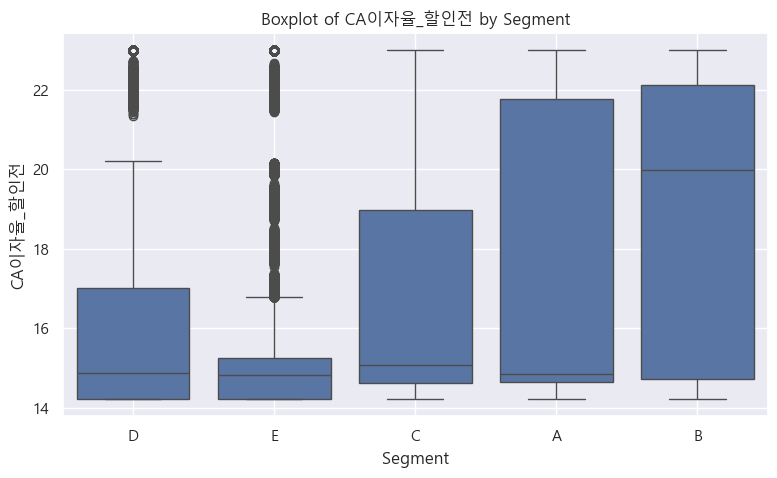


📌 유의한 변수: CL이자율_할인전 → Tukey HSD & Boxplot 진행 중...


,group1,group2,meandiff,p-adj,lower,upper,reject
0,A,B,1.1628,0.0000,0.5077,1.8179,True
1,A,C,-0.1355,0.5204,-0.3717,0.1008,False
2,A,D,-0.2577,0.0238,-0.4934,-0.0221,True
3,A,E,-0.4696,0.0000,-0.7050,-0.2342,True
4,B,C,-1.2983,0.0000,-1.9100,-0.6866,True
5,B,D,-1.4206,0.0000,-2.0321,-0.8090,True
6,B,E,-1.6324,0.0000,-2.2439,-1.0210,True
7,C,D,-0.1223,0.0000,-0.1463,-0.0983,True
8,C,E,-0.3342,0.0000,-0.3554,-0.3129,True
9,D,E,-0.2119,0.0000,-0.2254,-0.1984,True


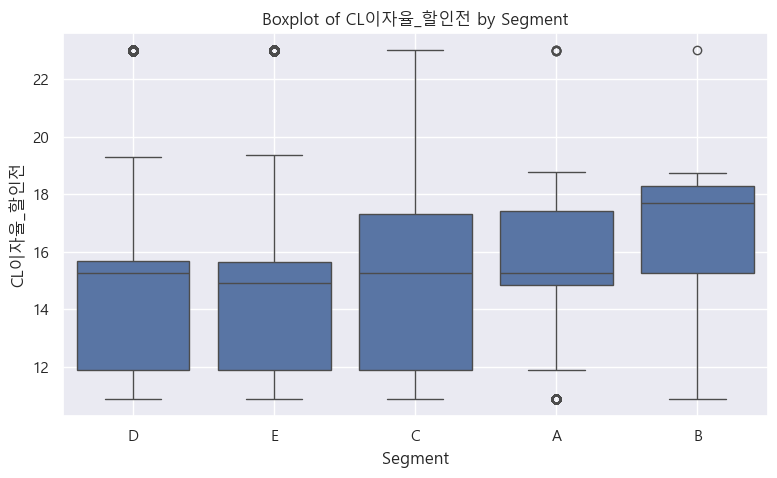


📌 유의한 변수: RV일시불이자율_할인전 → Tukey HSD & Boxplot 진행 중...


,group1,group2,meandiff,p-adj,lower,upper,reject
0,A,B,1.2884,0.0000,0.7486,1.8282,True
1,A,C,0.2287,0.0118,0.0340,0.4233,True
2,A,D,0.0854,0.7512,-0.1087,0.2796,False
3,A,E,-0.2919,0.0004,-0.4859,-0.0980,True
4,B,C,-1.0597,0.0000,-1.5638,-0.5557,True
5,B,D,-1.2030,0.0000,-1.7068,-0.6991,True
6,B,E,-1.5803,0.0000,-2.0841,-1.0765,True
7,C,D,-0.1432,0.0000,-0.1630,-0.1235,True
8,C,E,-0.5206,0.0000,-0.5381,-0.5031,True
9,D,E,-0.3774,0.0000,-0.3885,-0.3662,True


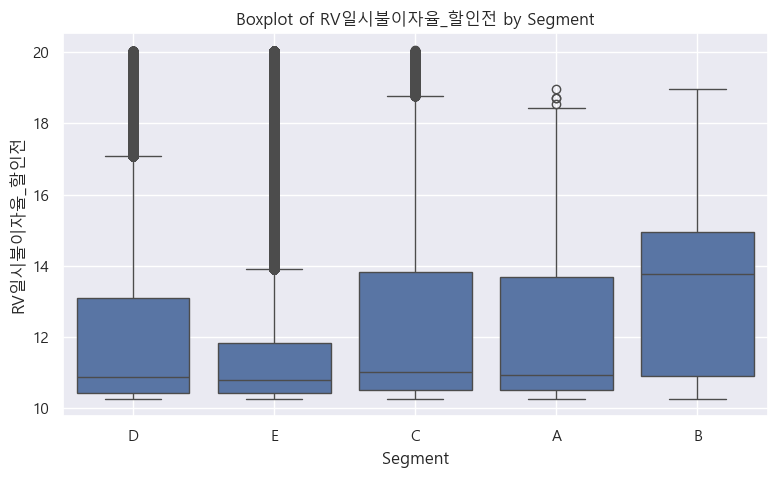


📌 유의한 변수: RV현금서비스이자율_할인전 → Tukey HSD & Boxplot 진행 중...


,group1,group2,meandiff,p-adj,lower,upper,reject
0,A,B,2.2265,0.0000,1.5593,2.8937,True
1,A,C,0.1128,0.7040,-0.1278,0.3534,False
2,A,D,-0.2037,0.1398,-0.4437,0.0363,False
3,A,E,-0.7756,0.0000,-1.0153,-0.5358,True
4,B,C,-2.1137,0.0000,-2.7367,-1.4906,True
5,B,D,-2.4302,0.0000,-3.0530,-1.8074,True
6,B,E,-3.0021,0.0000,-3.6248,-2.3794,True
7,C,D,-0.3166,0.0000,-0.3410,-0.2921,True
8,C,E,-0.8884,0.0000,-0.9100,-0.8668,True
9,D,E,-0.5718,0.0000,-0.5856,-0.5581,True


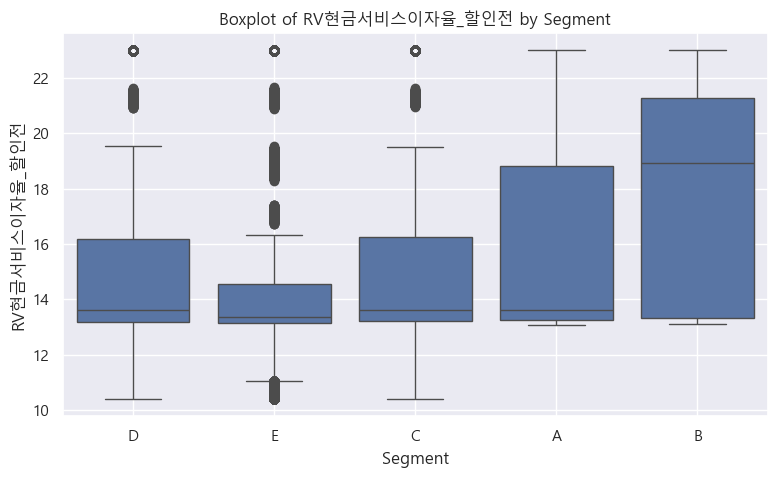


📌 유의한 변수: RV약정청구율 → Tukey HSD & Boxplot 진행 중...


,group1,group2,meandiff,p-adj,lower,upper,reject
0,A,B,14.1805,0.0002,5.1153,23.2456,True
1,A,C,4.5232,0.0015,1.2546,7.7919,True
2,A,D,7.6106,0.0000,4.3498,10.8715,True
3,A,E,0.6508,0.9826,-2.6063,3.9079,False
4,B,C,-9.6572,0.0160,-18.1221,-1.1924,True
5,B,D,-6.5698,0.2123,-15.0317,1.8920,False
6,B,E,-13.5297,0.0001,-21.9901,-5.0693,True
7,C,D,3.0874,0.0000,2.7553,3.4195,True
8,C,E,-3.8724,0.0000,-4.1659,-3.5789,True
9,D,E,-6.9598,0.0000,-7.1466,-6.7731,True


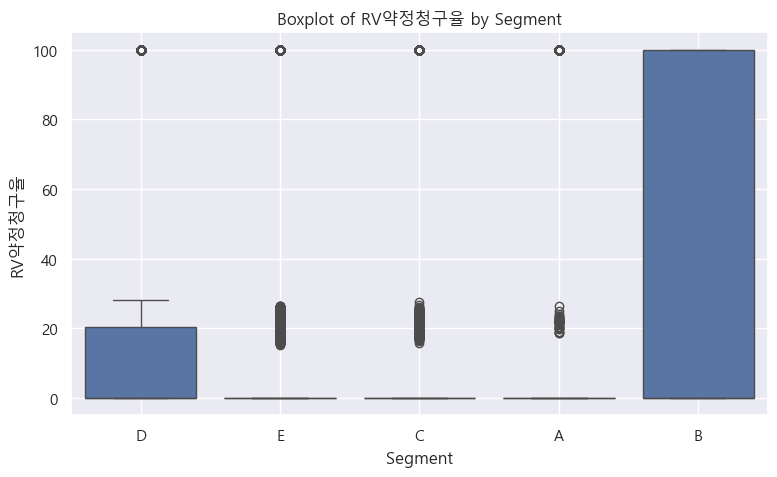


📌 유의한 변수: RV최소결제비율 → Tukey HSD & Boxplot 진행 중...


,group1,group2,meandiff,p-adj,lower,upper,reject
0,A,B,1.4738,0.0005,0.4831,2.4645,True
1,A,C,0.5447,0.0003,0.1875,0.9020,True
2,A,D,0.3283,0.0878,-0.0281,0.6846,False
3,A,E,0.0776,0.9760,-0.2784,0.4335,False
4,B,C,-0.9290,0.0484,-1.8541,-0.0039,True
5,B,D,-1.1455,0.0065,-2.0703,-0.2207,True
6,B,E,-1.3962,0.0004,-2.3208,-0.4716,True
7,C,D,-0.2165,0.0000,-0.2527,-0.1802,True
8,C,E,-0.4672,0.0000,-0.4992,-0.4351,True
9,D,E,-0.2507,0.0000,-0.2711,-0.2303,True


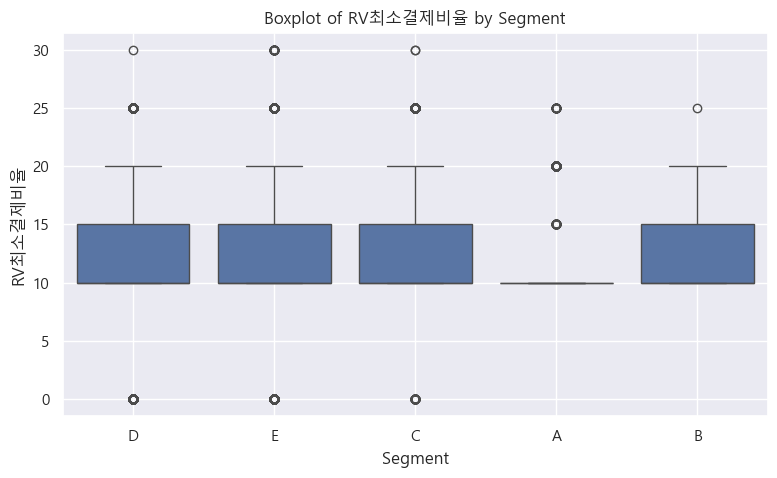


📌 유의한 변수: 카드이용한도금액_B1M → Tukey HSD & Boxplot 진행 중...


,group1,group2,meandiff,p-adj,lower,upper,reject
0,A,B,-74676.6489,0.0,-85317.1307,-64036.1672,True
1,A,C,-100365.5414,0.0,-104202.2466,-96528.8362,True
2,A,D,-128979.1537,0.0,-132806.6428,-125151.6646,True
3,A,E,-152450.7175,0.0,-156273.8577,-148627.5773,True
4,B,C,-25688.8925,0.0,-35624.7937,-15752.9913,True
5,B,D,-54302.5048,0.0,-64234.8508,-44370.1587,True
6,B,E,-77774.0686,0.0,-87704.7396,-67843.3976,True
7,C,D,-28613.6123,0.0,-29003.4239,-28223.8007,True
8,C,E,-52085.1761,0.0,-52429.6780,-51740.6741,True
9,D,E,-23471.5638,0.0,-23690.7607,-23252.3669,True


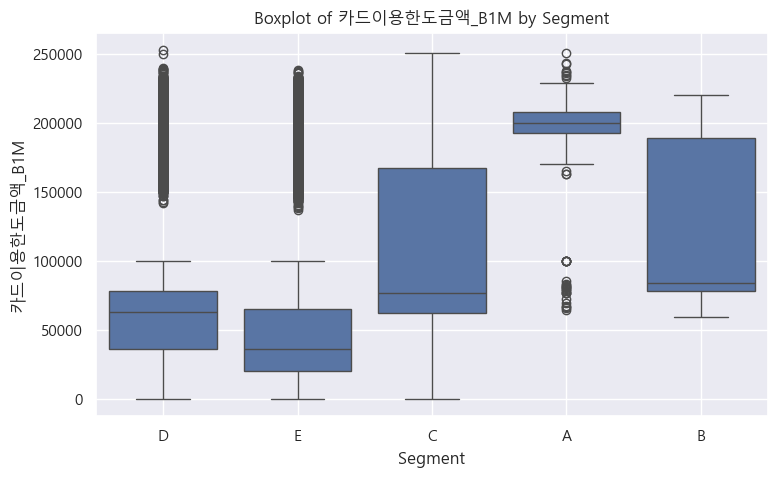


📌 유의한 변수: 카드이용한도금액_B2M → Tukey HSD & Boxplot 진행 중...


,group1,group2,meandiff,p-adj,lower,upper,reject
0,A,B,-75325.8104,0.0,-85933.9089,-64717.7120,True
1,A,C,-101143.3128,0.0,-104968.3414,-97318.2843,True
2,A,D,-129593.1857,0.0,-133409.0262,-125777.3452,True
3,A,E,-153020.4519,0.0,-156831.9567,-149208.9470,True
4,B,C,-25817.5024,0.0,-35723.1646,-15911.8401,True
5,B,D,-54267.3753,0.0,-64169.4932,-44365.2574,True
6,B,E,-77694.6414,0.0,-87595.0894,-67794.1935,True
7,C,D,-28449.8729,0.0,-28838.4981,-28061.2477,True
8,C,E,-51877.1391,0.0,-52220.5926,-51533.6856,True
9,D,E,-23427.2662,0.0,-23645.7960,-23208.7363,True


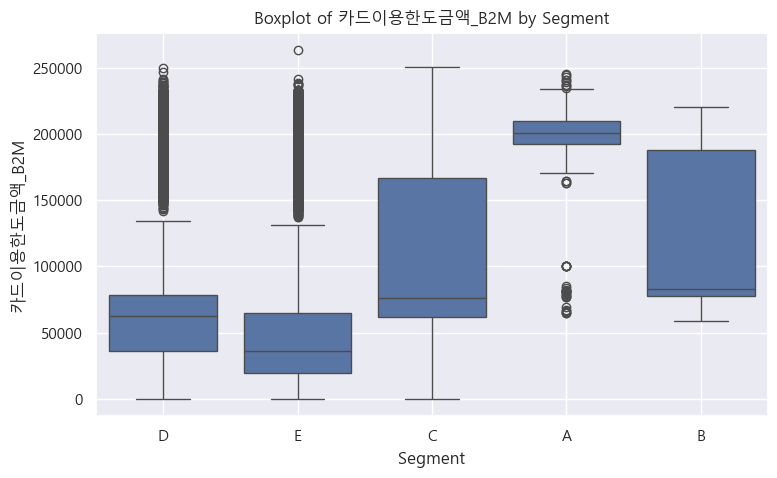

In [33]:
numerical_cols = [col for col in column1 + column2 if col != 'Segment_e']
anova_results = []
tukey_all_results = {}

for col in numerical_cols:
    try:
        fstat, pval = run_anova(all_df, 'Segment', col)
        conclusion = '✅ 유의함' if pval < 0.05 else '❌ 불충분'
        anova_results.append({'변수': col, 'F-stat': round(fstat, 4), 'p-value': round(pval, 6), '결론': conclusion})
        
        if pval < 0.05:
            print(f"\n📌 유의한 변수: {col} → Tukey HSD & Boxplot 진행 중...")
            tukey_df = run_tukey(all_df, 'Segment', col)
            tukey_all_results[col] = tukey_df  # 저장
            display(tukey_df)
            plot_box(all_df, 'Segment', col)

    except Exception as e:
        anova_results.append({'변수': col, 'F-stat': None, 'p-value': None, '결론': f'⚠ 오류: {e}'})
